In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
import random
from qiskit.providers.aer import noise
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington ibmq_16_melbourne
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


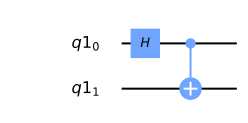

In [2]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


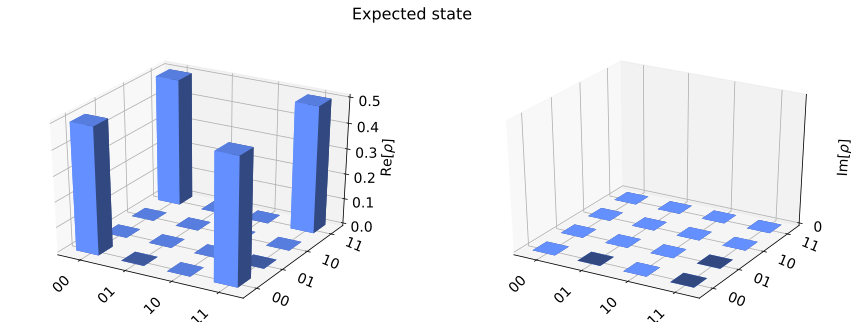

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

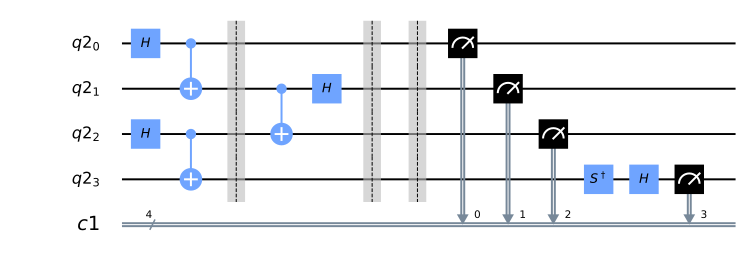

In [4]:
qr = QuantumRegister(4)
cr= ClassicalRegister(4)
qc1 = QuantumCircuit(qr)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qc1.barrier()
qcz=state_tomography_circuits(qc1,[qr])
qct=[qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]
qct[7].draw(output='mpl')

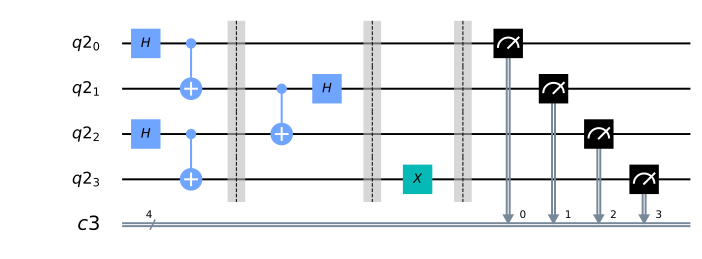

In [5]:
qc2 = QuantumCircuit(qr)
qc3 = QuantumCircuit(qr)
qc4 = QuantumCircuit(qr)
qcs = [qct,qc2,qc3,qc4]
for qc in range(3):
    q2 = QuantumCircuit(qr)
    if qc == 0 or qc == 2:
        q2.z(3)
    if qc == 1 or qc == 2:
        q2.x(3)
    p= qc1 +q2
    q= state_tomography_circuits(p,[qr])
    qcf=[q[24],q[25],q[26],q[51],q[52],q[53],q[78],q[79],q[80]]
    qcs[qc+1] =qcf
qcs[2][8].draw(output='mpl')

In [6]:
#mitigation measurement
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qct[8].qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,backend = device,shots = 1024,optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


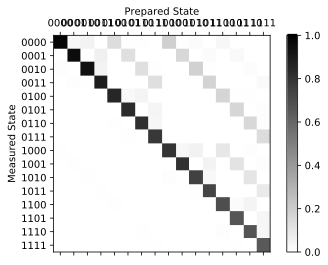

In [7]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [8]:
backends = [simulator,device,0]
measureqbit= [qreg[0],qreg[3]]
result =[0,0,0,0]
x=0
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101', '1101', '0110', '1110', '0111', '1111']
paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
for be in backends:
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    z=0
    for qc in qcs:
        qst_circuit = qc
        if be == simulator:
            job = execute(qst_circuit, simulator, shots=1000,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        if be == device:
            job = execute(qst_circuit, be, shots=1000)
            job_monitor(job)
            result[x] = job.result()
            x=x+1
        if be == 0:
            tom = StateTomographyFitter(meas_filter.apply(result[x]),qst_circuit)
            x=x+1
        else:
            tom = StateTomographyFitter(job.result(), qst_circuit)
        for pauli in paulis:
            for bit in bits:
                if bit not in tom.data[pauli]:
                    tom.data[pauli][bit]=0
        y=0
        for bas in basis:
            state.update({bas: {'00': state[bas]['00']+tom.data[paulis[y]][bits[4*z]],
                                '10': state[bas]['10']+tom.data[paulis[y]][bits[4*z+1]],
                                '01': state[bas]['01']+tom.data[paulis[y]][bits[4*z+2]],
                                '11': state[bas]['11']+tom.data[paulis[y]][bits[4*z+3]]}})
            y=y+1
        z=z+1        
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)
        x=0
    if be == 0:
        state_err = state
        print('The corrected state for device is', state)

The full state for simulator is {'XX': {'00': 442, '10': 61, '01': 89, '11': 402}, 'YX': {'00': 269, '10': 238, '01': 285, '11': 186}, 'ZX': {'00': 292, '10': 219, '01': 271, '11': 203}, 'XY': {'00': 279, '10': 199, '01': 269, '11': 204}, 'YY': {'00': 105, '10': 399, '01': 419, '11': 47}, 'ZY': {'00': 277, '10': 217, '01': 258, '11': 207}, 'XZ': {'00': 266, '10': 251, '01': 298, '11': 229}, 'YZ': {'00': 289, '10': 265, '01': 284, '11': 222}, 'ZZ': {'00': 444, '10': 40, '01': 63, '11': 442}}
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
The full state for device is {'XX': {'00': 486, '10': 40, '01': 111, '11': 358}, 'YX': {'00': 347, '10': 192, '01': 264, '11': 238}, 'ZX': {'00': 319, '10': 199, '01': 301, '11': 185}, 'XY': {'00': 319, '10': 202, '01': 272, '11': 172}, 'YY': {'00': 163, '10': 347, '01': 456, '11': 44}, 'ZY': {'00': 335, '10': 235, '01': 272, '11': 177}, 'XZ': {'00': 310

In [9]:
# fidelity processing for sim and dev
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

# simulator Bloch vector
r_sim=[0,0,0,0,0,0,0,0,0]
ri_sim=[0,0,0,0,0,0,0,0,0]
ri2_sim=[0,0,0,0,0,0,0,0,0]
riav_sim=[0,0,0]
riav2_sim=[0,0,0]
state_tot=[state_sim,state_dev,state_err]
rho=[0,0,0]
t=0
for stat in state_tot:
    r=0
    for bas in basis:
        r_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(-1)+stat[bas]['01']*(-1)+stat[bas]['11']*1)/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        ri_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(-1)+stat[bas]['11']*(-1))/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        r=r+1
    #
    basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']
    r=0
    for bas in basis2:
        ri2_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(-1)+stat[bas]['01']*(1)+stat[bas]['11']*(-1))/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        r=r+1
    for i in range(0,3):
        riav_sim[i]=(ri_sim[3*i]+ri_sim[3*i+1]+ri_sim[3*i+2])/3
        riav2_sim[i]=(ri2_sim[3*i]+ri2_sim[3*i+1]+ri2_sim[3*i+2])/3
    rho[t] = (1/4)*(Iden+r_sim[0]*XXPaul+r_sim[1]*XYPaul+r_sim[2]*XZPaul+
                 r_sim[3]*YXPaul+r_sim[4]*YYPaul+r_sim[5]*YZPaul+
                 r_sim[6]*ZXPaul+r_sim[7]*ZYPaul+r_sim[8]*ZZPaul+
                 riav_sim[0]*IXPaul+riav2_sim[0]*XIPaul+riav_sim[1]*IYPaul+
                 riav2_sim[1]*YIPaul+riav_sim[2]*IZPaul+riav2_sim[2]*ZIPaul)
    t=t+1

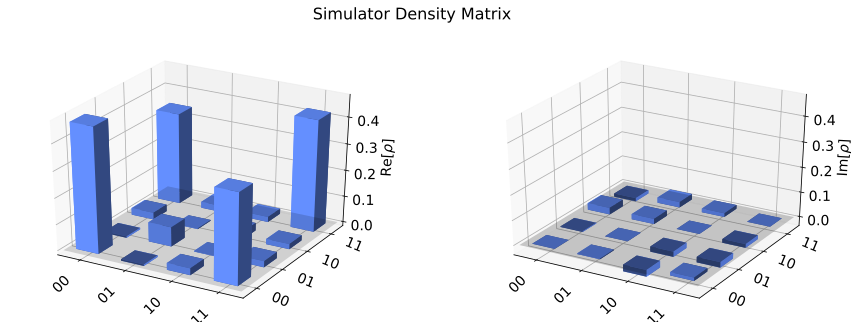

In [10]:
plot_state_city(rho[0], title='Simulator Density Matrix')

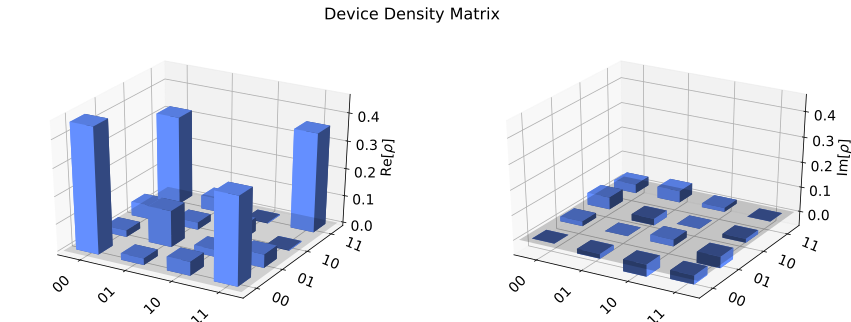

In [11]:
plot_state_city(rho[1], title='Device Density Matrix')

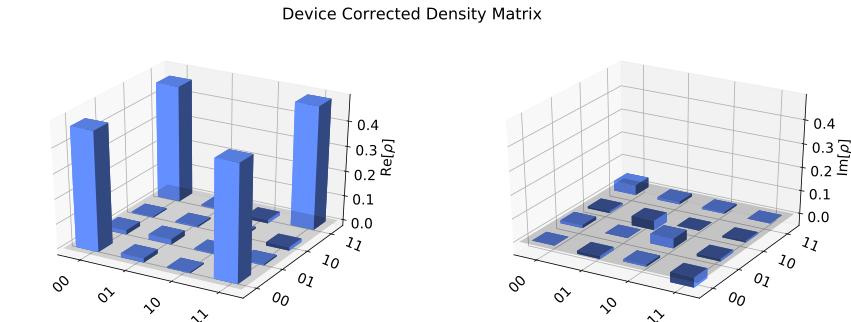

In [12]:
plot_state_city(rho[2], title='Device Corrected Density Matrix')

In [13]:
Sim_Fidelity = state_fidelity(psi_expected, rho[0], validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho[1], validate=False)
Err_Fidelity = state_fidelity(psi_expected, rho[2], validate=False)
print('Simulator Fidelity:', Sim_Fidelity)
print('Device Fidelity:', Dev_Fidelity)
print('Corrected Device Fidelity:', Err_Fidelity)

Simulator Fidelity: 0.7941239674293981
Device Fidelity: 0.7298504836954511
Corrected Device Fidelity: 0.9528758635626158


In [14]:
counts =[0,0,0,0]
for i in range(0,4):
    counts[i]=result[i].get_counts(qct[8])
countsdev = {'00': counts[0]["0000"]+counts[1]["0010"]+counts[2]["0100"]+counts[3]["0110"],'10': counts[0]["1000"]+counts[1]["1010"]+counts[2]["1100"]+counts[3]["1110"],'01': counts[0]["0001"]+counts[1]["0011"]+counts[2]["0101"]+counts[3]["0111"],'11': counts[0]["1001"]+counts[1]["1011"]+counts[2]["1101"]+counts[3]["1111"]}

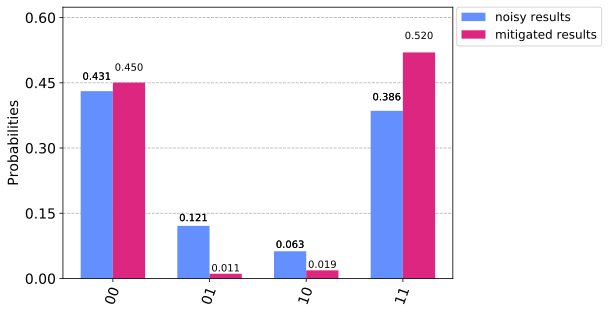

In [15]:
meas_filter = meas_fitter.filter
mitres = [0,0,0,0]
mitcounts = [0,0,0,0]
mitvec = [0,0,0,0]
for i in range(0,4):
    mitres[i] = meas_filter.apply(result[i])
    mitcounts[i] = mitres[i].get_counts(qct[8])
    for bit in bits:
        if bit not in mitcounts[i]:
            mitcounts[i][bit] = 0   
countsdev2 = {'00': mitcounts[0]["0000"]+mitcounts[1]["0010"]+mitcounts[2]["0100"]+
              mitcounts[3]["0110"],'10': mitcounts[0]["1000"]+mitcounts[1]["1010"]+mitcounts[2]["1100"]+
              mitcounts[3]["1110"],'01': mitcounts[0]["0001"]+mitcounts[1]["0011"]+mitcounts[2]["0101"]+
              mitcounts[3]["0111"],'11': mitcounts[0]["1001"]+mitcounts[1]["1011"]+mitcounts[2]["1101"]+
              mitcounts[3]["1111"]}

plot_histogram([countsdev, countsdev2], legend = ['noisy results', 'mitigated results'])